In [14]:
# import libraries used throughout the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn
import math
from sklearn import svm, metrics, ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression


In [2]:
#check version
sklearn.__version__

'1.3.0'

The dataset we use is from the paper <a href="https://www.researchgate.net/publication/228780408_Using_data_mining_to_predict_secondary_school_student_performance">Using data mining to predict secondary school student performance</a> by Paulo Cortez and Alice Silva.

The following blocks use the Portugese dataset.

In [7]:
data = pd.read_csv('data/student-por.csv', delimiter=';')
# heatmap requires numerical values
data = data.replace(to_replace=['M', 'F'], value=[0,1]) #sex
data = data.replace(to_replace=['GP', 'MS'], value=[0,1]) #school
data = data.replace(to_replace=['A', 'T'], value=[0,1]) #Pstatus
data = data.replace(to_replace=['GT3', 'LE3'], value=[0,1]) #famsize
data = data.replace(to_replace=['U', 'R'], value=[0,1]) #address
data = data.replace(to_replace=['father', 'mother'], value=[0,1]) #guardian
data = data.replace(to_replace=['at_home', 'health', 'other', 'services', 'teacher'], value=[0,1,2,3,4]) #Mjob, Fjob
data = data.replace(to_replace=['course', 'other', 'home', 'reputation'], value=[0,1,2,3]) #reason
data = data.replace(to_replace=['no', 'yes'], value=[0,1]) #fatherd, nursery, higher, famsup, romantic
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,1,18,0,0,0,4,4,0,4,...,4,3,4,1,1,3,4,0,11,11
1,0,1,17,0,0,1,1,1,0,2,...,5,3,3,1,1,3,2,9,11,11
2,0,1,15,0,1,1,1,1,0,2,...,4,3,2,2,3,3,6,12,13,12
3,0,1,15,0,0,1,4,2,1,3,...,3,2,2,1,1,5,0,14,14,14
4,0,1,16,0,0,1,3,3,2,2,...,4,3,2,1,2,5,0,11,13,13


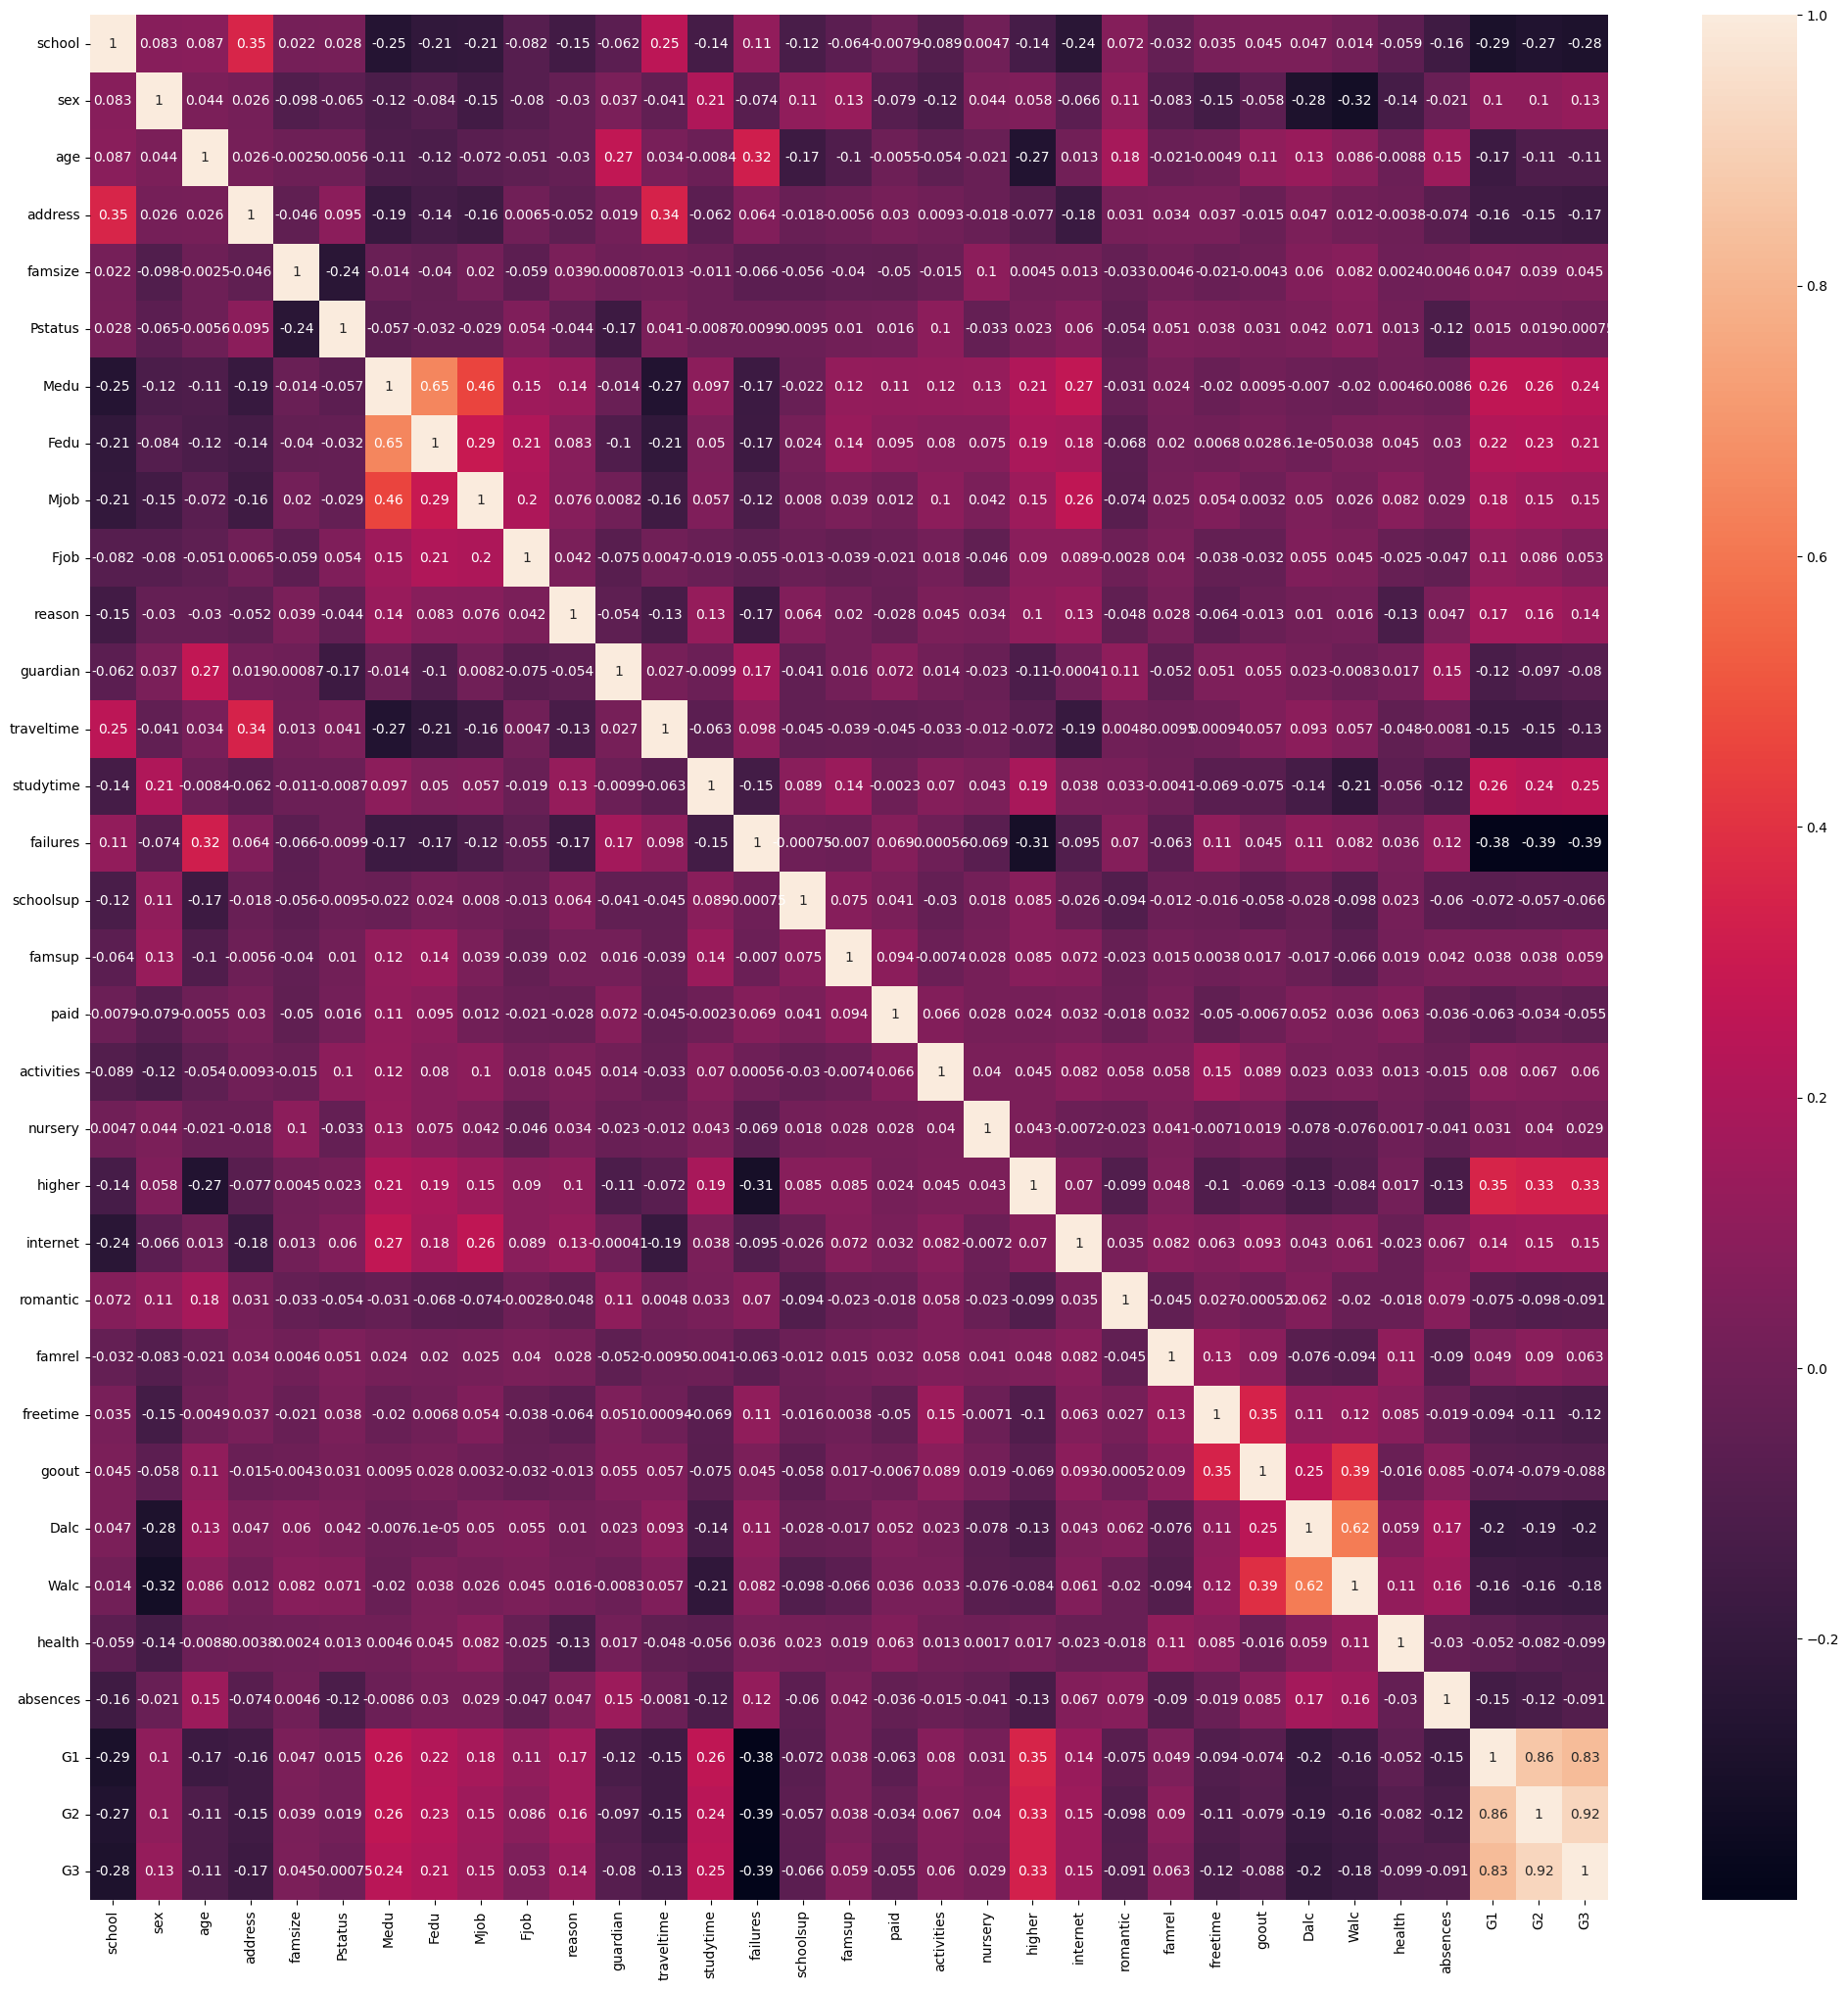

In [8]:
# add correlation matrix to see which features are highly correlated
corr_data = data.select_dtypes(include='number')
corr = corr_data.corr()
fig, ax = plt.subplots(figsize=(25,25))
ax = sns.heatmap(corr, annot=True)

# features highly correlated with sex: Dalc(-), Walc(-), studytime, freetime(-), Mjob(-), health(-), G3, famsup, Medu(-), romantic

In [200]:
# split data for training and testing (80:20), use all features except predictor and sensitive attribute
features = data
X = features.drop(columns=['G3', 'sex'])
y = data['G3'] # predict final grade
prot_atr = data['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [201]:
# binary classifier: pass if >= 10, else fail

# redefine values for binary classification
y_train_binary = y_train.tolist()
y_test_binary = y_test.tolist()
for i in range(len(y_train_binary)):
    if y_train_binary[i] >= 10:
        y_train_binary[i] = 1
    else:
        y_train_binary[i] = 0
for i in range(len(y_test_binary)):
    if y_test_binary[i] >= 10:
        y_test_binary[i] = 1
    else:
        y_test_binary[i] = 0

# we use SVM, paper tried 5 different models
clf = svm.SVC().fit(X_train, y_train_binary)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test_binary, pred) # 93.1% accuracy

0.8860759493670886

In [202]:
# 5 level classification as defined in paper
y_train_5 = y_train.replace(to_replace=[[20, 19, 18, 17, 16], [15, 14], [13, 12], [11, 10], [9,8,7,6,5,4,3,2,1]], value=[1, 2, 3, 4, 5])
y_test_5 = y_test.replace(to_replace=[[20, 19, 18, 17, 16], [15, 14], [13, 12], [11, 10], [9,8,7,6,5,4,3,2,1]], value=[1, 2, 3, 4, 5])
clf = svm.SVC().fit(X_train, y_train_5)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test_5, pred) # 70% accuracy

0.6708860759493671

In [104]:
def precision_whole_population(label_test, predictions):
  return precision_score(label_test, predictions)

def recall_whole_population(label_test, predictions):
  return recall_score(label_test, predictions)

def dataframe_with_predictions(feature_prot_atr, label_test, predictions):
    dataframe = pd.DataFrame({'sex': feature_prot_atr, 'G3': label_test, 'prediction': predictions})
    sex_mapping = {1: 'female', 0: 'male'}
    dataframe['sex'] = dataframe['sex'].map(sex_mapping)
    return dataframe

def statistical_parity(dataFrame):
    return dataFrame.groupby('sex')['prediction'].mean()

def true_positive_rate(dataFrame):
    return dataFrame.groupby('sex').apply(lambda x: np.sum((x['G3'] >= 10) & (x['prediction'] >= 10)) / np.sum(x['G3'] >= 10))

def false_positive_rate(dataFrame):
    return dataFrame.groupby('sex').apply(lambda x: np.sum((x['G3'] < 10) & (x['prediction'] >= 10)) / np.sum(x['G3'] < 10))

In [212]:
# regression: score determined by RMSE

regr = svm.SVR().fit(X_train, y_train)
pred = regr.predict(X_test)
metrics.mean_squared_error(y_test, pred) # 1.70

results_df = pd.DataFrame({'sex': data.loc[X_test.index, 'sex'], 'G3': y_test, 'prediction': pred})
# print(results_df)

print("---STATISTICAL PARITY---")
print(statistical_parity(results_df))

print("---TRUE POSITIVE RATE---")
print(true_positive_rate(results_df))

print("---FALSE POSITIVE RATE---")
print(false_positive_rate(results_df))


---STATISTICAL PARITY---
sex
0    11.709512
1    10.060379
Name: prediction, dtype: float64
---TRUE POSITIVE RATE---
sex
0    0.862069
1    0.782609
dtype: float64
---FALSE POSITIVE RATE---
sex
0    0.000000
1    0.066667
dtype: float64


In [213]:
# classification: try to predict sensitive attribute (sex) using highly correlated features
features = data[['Dalc', 'Walc', 'studytime', 'freetime']]
X = features
y = data['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred) # 75.4% accuracy

0.6455696202531646

In [214]:
# classification: predict sensitive attribute using all features except predictor, grades
features = data
X = features.drop(columns=['G1', 'G2', 'G3', 'sex'])
y = data['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred) #67.7% accuracy

0.5569620253164557

In [215]:
# classification: predict sensitive attribute using all features except predictor, grades
features = data
X = features.drop(columns=['G1', 'G2', 'G3', 'Pstatus'])
y = data['Pstatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred) #83.8% accuracy

0.8860759493670886

The following blocks use the Mathematics dataset.

In [216]:
data = pd.read_csv('data/student-mat.csv', delimiter=';')
# heatmap requires numerical values
data = data.replace(to_replace=['M', 'F'], value=[0,1]) #sex
data = data.replace(to_replace=['GP', 'MS'], value=[0,1]) #school
data = data.replace(to_replace=['A', 'T'], value=[0,1]) #Pstatus
data = data.replace(to_replace=['GT3', 'LE3'], value=[0,1]) #famsize
data = data.replace(to_replace=['U', 'R'], value=[0,1]) #address
data = data.replace(to_replace=['father', 'mother'], value=[0,1]) #guardian
data = data.replace(to_replace=['at_home', 'health', 'other', 'services', 'teacher'], value=[0,1,2,3,4]) #Mjob, Fjob
data = data.replace(to_replace=['course', 'other', 'home', 'reputation'], value=[0,1,2,3]) #reason
data = data.replace(to_replace=['no', 'yes'], value=[0,1]) #fatherd, nursery, higher, famsup, romantic
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,1,18,0,0,0,4,4,0,4,...,4,3,4,1,1,3,6,5,6,6
1,0,1,17,0,0,1,1,1,0,2,...,5,3,3,1,1,3,4,5,5,6
2,0,1,15,0,1,1,1,1,0,2,...,4,3,2,2,3,3,10,7,8,10
3,0,1,15,0,0,1,4,2,1,3,...,3,2,2,1,1,5,2,15,14,15
4,0,1,16,0,0,1,3,3,2,2,...,4,3,2,1,2,5,4,6,10,10


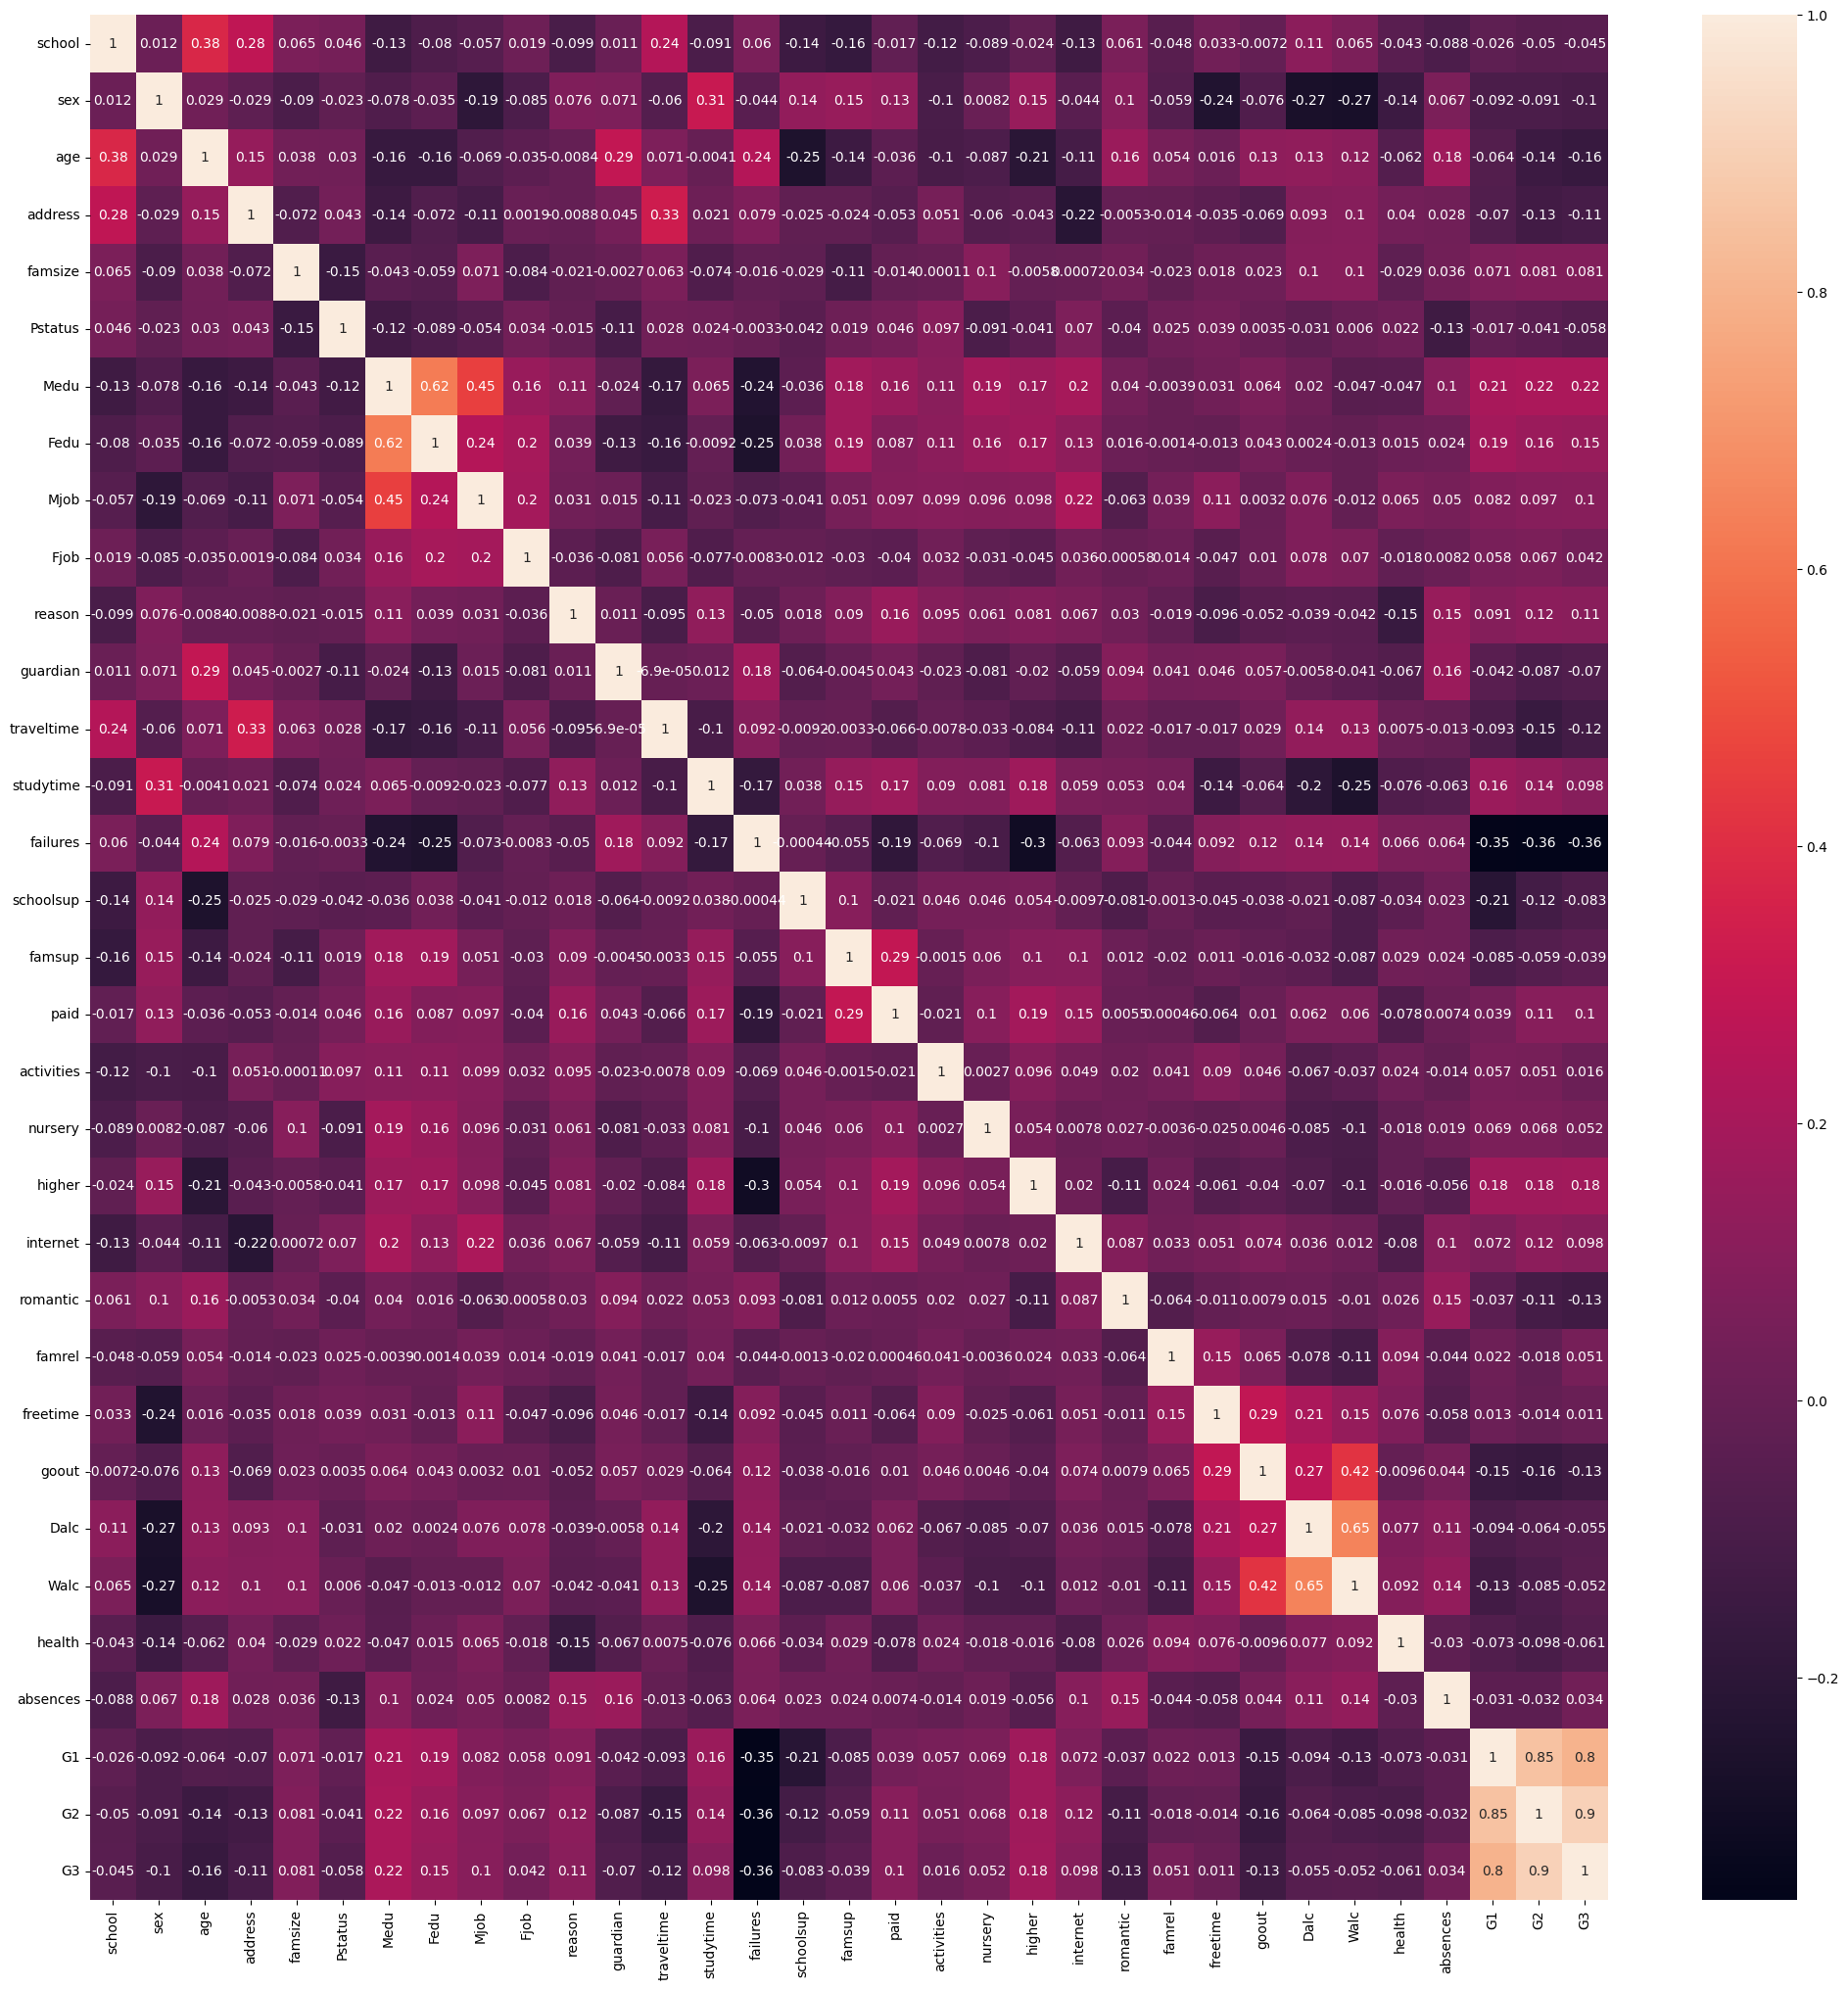

In [217]:
# add correlation matrix to see which features are highly correlated
corr_data = data.select_dtypes(include='number')
corr = corr_data.corr()
fig, ax = plt.subplots(figsize=(25,25))
ax = sns.heatmap(corr, annot=True)

# features highly correlated with sex: studytime, Dalc(-), Walc(-), freetime(-), Mjob(-), higher, schoolsup, famsup, health(-), paid

In [226]:
# Precision
def precision_whole_population(label_test, predictions):
    return precision_score(label_test, predictions)

# Statistical parity
def statistical_parity_sex(dataframe):
    return dataframe.groupby('sex')['prediction'].value_counts(normalize=True).unstack()

# TPR
def true_positive_rate(dataframe):
    tpr_0 = recall_score(dataframe['sex'], dataframe['prediction'], pos_label=0)
    tpr_1 = recall_score(dataframe['sex'], dataframe['prediction'], pos_label=1)
    return {'TPR_0': tpr_0, 'TPR_1': tpr_1}

# FPR
def false_positive_rate(dataframe):
    # Group by 'sex' and calculate FPR for each group
    fpr_0 = dataframe.groupby('sex').apply(lambda x: confusion_matrix(x['sex'], x['prediction'])[0,1] / (confusion_matrix(x['sex'], x['prediction'])[0,0] + confusion_matrix(x['sex'], x['prediction'])[0,1])).loc[0]
    fpr_1 = dataframe.groupby('sex').apply(lambda x: confusion_matrix(x['sex'], x['prediction'])[1,0] / (confusion_matrix(x['sex'], x['prediction'])[1,0] + confusion_matrix(x['sex'], x['prediction'])[1,1])).loc[1]
    
    return {'FPR_0': fpr_0, 'FPR_1': fpr_1}

def dataframe_with_predictions(features, label_test, predictions):
    dataframe = features.copy()
    dataframe['sex'] = label_test.values
    dataframe['prediction'] = predictions
    return dataframe

In [227]:
# RF classifier: predict sex from features
features = data[['studytime', 'Walc', 'freetime', 'Mjob', 'schoolsup', 'health']]
X = features
y = data['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = ensemble.RandomForestClassifier().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred)
metrics.f1_score(y_test, pred)

# Fairness metrics

results_df = dataframe_with_predictions(X_test, y_test, pred)

# precision
print("---PRECISION---")
precision = precision_whole_population(y_test, pred)
print(f"Precision for the whole population: {precision:.4f}")
ppv = precision_score(y_test, pred)

ppv_label_0 = precision_score(y_test, pred, pos_label=0)
ppv_label_1 = precision_score(y_test, pred, pos_label=1)

print(f'Precision for label 0: {ppv_label_0:.4f}')
print(f'Precision for label 1: {ppv_label_1:.4f}')

# calculate the difference in PPV between the groups
ppv_diff = abs(ppv_label_0 - ppv_label_1)
print("Difference in PPV: ", ppv_diff)

# statistical parity
print("---STATISTICAL PARITY---")
stat_parity_results = statistical_parity_sex(results_df)
print(stat_parity_results)


# TPR
tpr_results = true_positive_rate(results_df)
print("---TRUE POSITIVE RATE---")
print(f"Class 0 (Male): {tpr_results['TPR_0']:.4f}")
print(f"Class 1 (Female): {tpr_results['TPR_1']:.4f}")


# FPR
fpr_results = false_positive_rate(results_df)
print("---FALSE POSITIVE RATE---")
print(f"Class 0 (Male): {fpr_results['FPR_0']:.4f}")
print(f"Class 1 (Female): {fpr_results['FPR_1']:.4f}")

---PRECISION---
Precision for the whole population: 0.5789
Precision for label 0: 0.6098
Precision for label 1: 0.5789
Difference in PPV:  0.03080872913992294
---STATISTICAL PARITY---
prediction         0         1
sex                           
0           0.609756  0.390244
1           0.421053  0.578947
---TRUE POSITIVE RATE---
Class 0 (Male): 0.6098
Class 1 (Female): 0.5789
---FALSE POSITIVE RATE---
Class 0 (Male): 0.3902
Class 1 (Female): 0.4211


/var/folders/5b/jzf6y2tn3l10f9rnm_9lfjtw0000gn/T/ipykernel_32259/3929352220.py:18: RuntimeWarning: invalid value encountered in scalar divide
  fpr_0 = dataframe.groupby('sex').apply(lambda x: confusion_matrix(x['sex'], x['prediction'])[0,1] / (confusion_matrix(x['sex'], x['prediction'])[0,0] + confusion_matrix(x['sex'], x['prediction'])[0,1])).loc[0]
/var/folders/5b/jzf6y2tn3l10f9rnm_9lfjtw0000gn/T/ipykernel_32259/3929352220.py:19: RuntimeWarning: invalid value encountered in scalar divide
  fpr_1 = dataframe.groupby('sex').apply(lambda x: confusion_matrix(x['sex'], x['prediction'])[1,0] / (confusion_matrix(x['sex'], x['prediction'])[1,0] + confusion_matrix(x['sex'], x['prediction'])[1,1])).loc[1]


In [229]:
# SVM classifier: predict sex from features
features = data[['studytime', 'Walc', 'freetime', 'Mjob', 'schoolsup', 'health']]
X = features
y = data['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred)
metrics.f1_score(y_test, pred)
print(metrics.classification_report(y_test, pred))

# Fairness metrics:

results_df = dataframe_with_predictions(X_test, y_test, pred)

# precision
print("---PRECISION---")
precision = precision_whole_population(y_test, pred)
print(f"Precision for the whole population: {precision:.4f}")
ppv = precision_score(y_test, pred)

ppv_label_0 = precision_score(y_test, pred, pos_label=0)
ppv_label_1 = precision_score(y_test, pred, pos_label=1)

print(f'Precision for label 0: {ppv_label_0:.4f}')
print(f'Precision for label 1: {ppv_label_1:.4f}')

# calculate the difference in PPV between the groups
ppv_diff = abs(ppv_label_0 - ppv_label_1)
print("Difference in PPV: ", ppv_diff)

# statistical parity
print("---STATISTICAL PARITY---")
stat_parity_results = statistical_parity_sex(results_df)
print(stat_parity_results)


# TPR
tpr_results = true_positive_rate(results_df)
print("---TRUE POSITIVE RATE---")
print(f"Class 0 (Male): {tpr_results['TPR_0']:.4f}")
print(f"Class 1 (Female): {tpr_results['TPR_1']:.4f}")


# FPR
fpr_results = false_positive_rate(results_df)
print("---FALSE POSITIVE RATE---")
print(f"Class 0 (Male): {fpr_results['FPR_0']:.4f}")
print(f"Class 1 (Female): {fpr_results['FPR_1']:.4f}")

              precision    recall  f1-score   support

           0       0.65      0.59      0.62        41
           1       0.60      0.66      0.62        38

    accuracy                           0.62        79
   macro avg       0.62      0.62      0.62        79
weighted avg       0.62      0.62      0.62        79

---PRECISION---
Precision for the whole population: 0.5952
Precision for label 0: 0.6486
Precision for label 1: 0.5952
Difference in PPV:  0.05341055341055345
---STATISTICAL PARITY---
prediction         0         1
sex                           
0           0.585366  0.414634
1           0.342105  0.657895
---TRUE POSITIVE RATE---
Class 0 (Male): 0.5854
Class 1 (Female): 0.6579
---FALSE POSITIVE RATE---
Class 0 (Male): 0.4146
Class 1 (Female): 0.3421


/var/folders/5b/jzf6y2tn3l10f9rnm_9lfjtw0000gn/T/ipykernel_32259/3929352220.py:18: RuntimeWarning: invalid value encountered in scalar divide
  fpr_0 = dataframe.groupby('sex').apply(lambda x: confusion_matrix(x['sex'], x['prediction'])[0,1] / (confusion_matrix(x['sex'], x['prediction'])[0,0] + confusion_matrix(x['sex'], x['prediction'])[0,1])).loc[0]
/var/folders/5b/jzf6y2tn3l10f9rnm_9lfjtw0000gn/T/ipykernel_32259/3929352220.py:19: RuntimeWarning: invalid value encountered in scalar divide
  fpr_1 = dataframe.groupby('sex').apply(lambda x: confusion_matrix(x['sex'], x['prediction'])[1,0] / (confusion_matrix(x['sex'], x['prediction'])[1,0] + confusion_matrix(x['sex'], x['prediction'])[1,1])).loc[1]


In [230]:
# RF classifier: predict cohabitation from features
features = data[['studytime', 'Walc', 'freetime', 'Mjob', 'schoolsup', 'health']]
X = features
y = data['Pstatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = ensemble.RandomForestClassifier().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred)
metrics.f1_score(y_test, pred)
print(metrics.classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.67      0.14      0.24        14
           1       0.90      0.99      0.94       105

    accuracy                           0.89       119
   macro avg       0.78      0.57      0.59       119
weighted avg       0.87      0.89      0.86       119



In [231]:
# SVM classifier: predict cohabitation from features
features = data[['studytime', 'Walc', 'freetime', 'Mjob', 'schoolsup', 'health']]
X = features
y = data['Pstatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred)
# metrics.f1_score(y_test, pred)

0.8860759493670886

deprecated: we tried making these models, but we decided not to use them in the end

In [232]:
# regression: predict whether parents are cohabitating
features = data[['famsize', 'guardian', 'address', 'Walc', 'activities', 'romantic', 'internet']]
X = features
y = data['Pstatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = sm.add_constant(X_train)
regr = sm.OLS(y_train, X_train).fit()
params = regr.params
regr.summary()

# regression: predict whether student is male or female
features = data[['studytime', 'Walc', 'freetime', 'Mjob', 'schoolsup', 'health']]
X = features
y = data['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = sm.add_constant(X_train)
regr = sm.OLS(y_train, X_train).fit()
params = regr.params
regr.summary()

# SVM classifier: predict combined education from features
data['combined_pedu'] = round((data['Medu'] + data['Fedu']) / 2)
features = data[['studytime', 'Walc', 'freetime', 'Mjob', 'schoolsup', 'health']]
X = features
y = data['combined_pedu']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred)
metrics.classification_report(y_test, pred)
# metrics.f1_score(y_test, pred)

# same as above, but this time, use intersectional fairness
data['combined_pedu'] = data['Medu'] + data['Fedu']
features = data[['studytime', 'Walc', 'freetime', 'Mjob', 'schoolsup', 'health']]
X = features
y = data['combined_pedu']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred)
# print(metrics.classification_report(y_test, pred))
# metrics.f1_score(y_test, pred)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

0.189873417721519